In [1]:
import torch
import torch.nn.functional as F
import torch.autograd as autograd
import torch.nn as nn

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision
# import tensorflow
from  torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)


In [3]:
BATCH_SIZE = 128     # number of data points in each batch
N_EPOCHS = 10       # times to run the model on complete data
INPUT_DIM = 28 * 28 # size of each input
HIDDEN_DIM = 256    # hidden dimension
LATENT_DIM = 20     # latent vector dimension
lr = 1e-3           # learning rate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


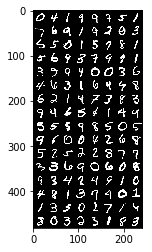

In [5]:

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))


In [6]:

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1152):
        return input.view(input.size(0), int(size/36), 6, 6)

In [7]:
class VAE(nn.Module):
    def __init__(self, h_dim=1568, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(8, 16, 3, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1),
            nn.MaxPool2d(3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, 1152)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(32, 64, 3, stride=1, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=1, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)

        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.fc4(z)
        z = self.decoder(z)
        print(z.shape)

        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [8]:
# image_channels = fixed_x.size(1)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model = VAE().to(device)
# model.load_state_dict(torch.load('vae.torch', map_location='cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [9]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [10]:
epochs = 20
for epoch in range(epochs):
    for idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        to_print = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch+1, idx * len(images), len(train_loader.dataset),
                100. * idx / len(train_loader), loss.data/BATCH_SIZE)
#         to                        epochs, loss.data/BATCH_SIZE, bce.data/BATCH_SIZE, kld.data/BATCH_SIZE)
        print(to_print)

# notify to android when finished training
notify(to_print, priority=1)

torch.save(vae.state_dict(), 'vae.torch')

torch.Size([128, 1, 28, 28])
Train Epoch: 1 [0/60000 (0%)]	Loss: 390.737488


/home/naman/miniconda3/lib/python3.5/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([128, 1, 28, 28])
Train Epoch: 1 [128/60000 (0%)]	Loss: 393.855865
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [256/60000 (0%)]	Loss: 388.272736
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [384/60000 (1%)]	Loss: 355.460297
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [512/60000 (1%)]	Loss: 290.943787
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [640/60000 (1%)]	Loss: 190.628937
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [768/60000 (1%)]	Loss: 5.029020
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [896/60000 (1%)]	Loss: -242.161102
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [1024/60000 (2%)]	Loss: -789.874878
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [1152/60000 (2%)]	Loss: -1523.656128
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [1280/60000 (2%)]	Loss: -3075.064209
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [1408/60000 (2%)]	Loss: -4652.851074
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [1536/60000 (3%)]	Loss: -5882.634277
torch.Size([128, 1, 28, 28])
Train Epoch: 1 [1664/6

KeyboardInterrupt: 

In [ ]:

def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))
